In [22]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [23]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # Means at initiatlization, the value has no effect on the output
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data = {self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) #if other = Value type fine, if not then wrap it
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __radd__(self,other): # other + self (allows operations like 2 + a since pythong will check if Value has __radd__ defined)
        return self + other

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other):
        return self - other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data** (other - 1)) * out.grad
            
        out._backward = _backward
        return out

    def __rmul__(self, other): # other * self (allows operations like 2 * a since pythong will check if Value has __rmul__ defined)
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1 # = self/other since any k**-1 is 1/k, then self * 1/k = self/k

    def __rtruediv__(self, other):
        return self / other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad = out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        #topological sort to build a graph where all edges continue in one direction
        #this allows us to hit all dependencies for a given node, since we need to know what came before it
        # Essentially, it guarentees that it will build the graph where the output node only adds itself to the grpah once all children nodes have been added
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        # for each node in the reverse of topo (starting at o, we called ._backward to do full backwards propogation)
        self.grad = 1.0 #(base output is always set to 1)
        for node in reversed(topo):
            node._backward()

In [24]:
from graphviz import Digraph

def trace(root):
    #builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            #if this value is a result of some oepration, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

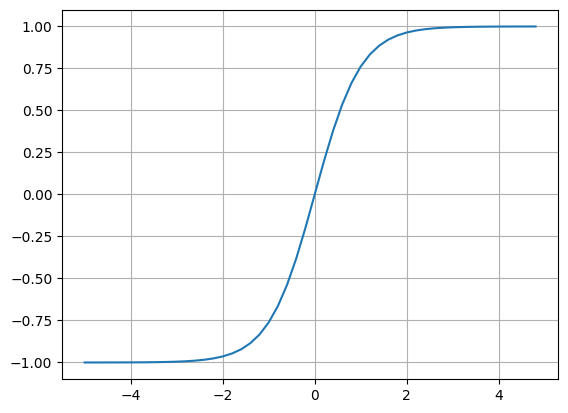

In [25]:
# Shows how tanh can squash inputs between -1 and 1. Like sigmod but more efficient
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [26]:
#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias of the neuron
b = Value(6.8813735870195432, label='b')

#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# Our neuron activation formula
n = x1w1x2w2 + b; n.label = 'n'

#our output
o = n.tanh(); o.label = 'o'

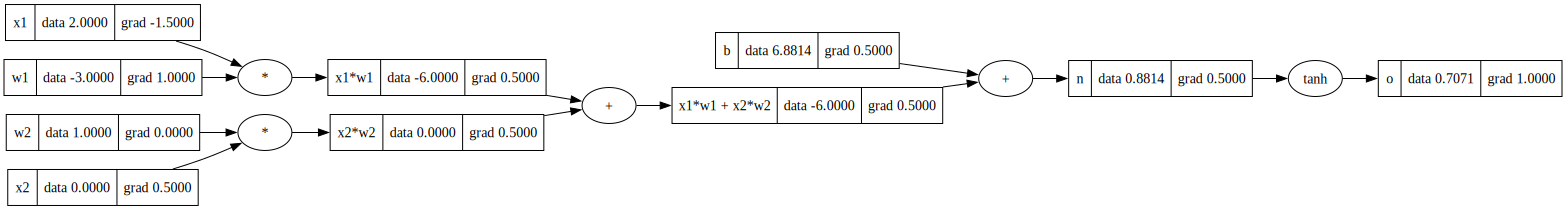

In [27]:
o.backward()
draw_dot(o)

In [28]:
# Manual back propogation to understand how a weight can influence the final neuron
o.grad = 1.0

n.grad = 0.5 #do/dn = 1 - o**2

b.grad = 0.5 # addition just passes the back propogates the gradient of n to both b and x1w1x2w2
x1w1x2w2.grad = 0.5

x2w2.grad = 0.5 #addition again back propogates the gradient of x1w1x2w2 to both x2w2 and x1w1
x1w1.grad = 0.5

x2.grad = w2.data * x2w2.grad #multiplciation backpropogates by mutiplying the derivate of x2w2 by the value of w2, which anything * 0 = 0
w2.grad = x2.data * x2w2.grad #same step applies here but since w2.data is 1 we know that 1 * any derivative is the derivative. 1 * 0.5 (x2w2.grad) = 0.5

x1.grad = w1.data * x1w1.grad # -3 * 0.5 = -1.5
w1.grad = x1.data * x1w1.grad # 2 * 0.5 = 1

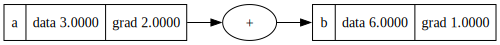

In [29]:
# What if a node is forward propogated twice? It causes a bug in our backward code, until we fix it
a = Value(3.0, label='a')
b = a + a; b.label ='b' #the deriviate of da/db should be 2 since da = 1, and 1+1 = 2
b.backward() #because in backward() self & other are the same object in this case, we're overwriting instead of adding them together
draw_dot(b)

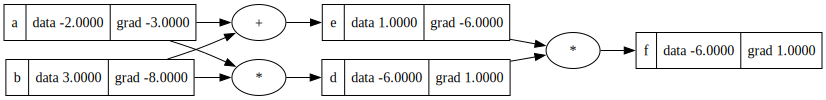

In [30]:
#Another example but a with more nodes
#Our earlier examples worked because each variable was used only once, but here we can see a & b used more than once
#This means d will back propgoate its gradient values to a & b, but then e will overwrite those once it back progogates its values
#To solve this problem we need accumulate the gradients (add them) instead of just setting them (+= instead of just = in our _backward() functions)
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a*b; d.label='d'
e = a+b; e.label='e'
f = d*e; f.label='f'

f.backward()
draw_dot(f)

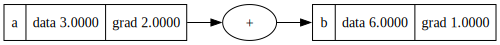

In [31]:
# now lets draw this with our fix in place
a = Value(3.0, label='a')
b = a + a; b.label ='b'
b.backward() 
draw_dot(b)

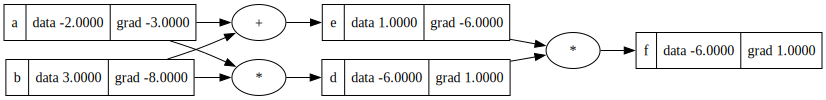

In [32]:
# now lets draw this with our fix in place
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a*b; d.label='d'
e = a+b; e.label='e'
f = d*e; f.label='f'

f.backward()
draw_dot(f)

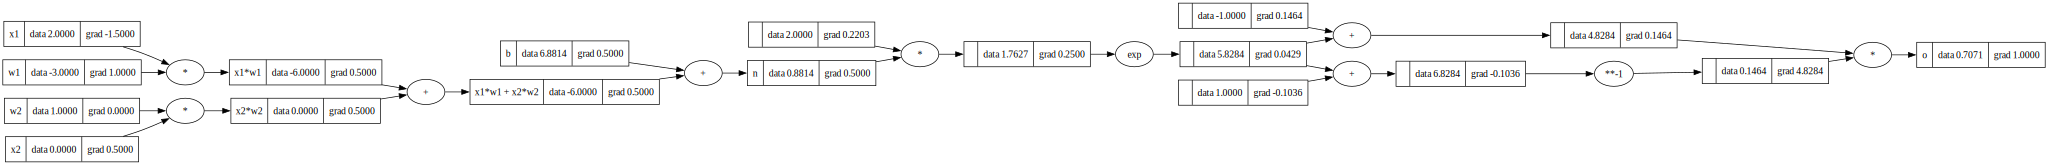

In [33]:
# Now lets break up the tanh funciton
#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias of the neuron
b = Value(6.8813735870195432, label='b')

#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# Our neuron activation formula
n = x1w1x2w2 + b; n.label = 'n'

#-- Breaking up tanh --
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'

# We should see the same results in data/gradients as our previous example, but with more oeprator nodes for tanh
o.backward()
draw_dot(o)

In [34]:
# Now lets do the same operations but using PyTorch to learn how the framework handles it
import torch

In [35]:
# By deafult Tensors use float64 so we need .double to represent our float32 scalar like Python
x1 = torch.Tensor([2.0]).double()               ; x1.requires_grad = True # For each leaf node we need to say they require gradients
x2 = torch.Tensor([0.0]).double()               ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()              ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

#Same as our micrograd but we need to call item in order to see the just tensor's data and not int type
print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [36]:
x1.grad.item()

-1.5000003851533106

In [37]:
# Now moving on to building our a neural net
# Neural nets are just a specific type of mathematical expersions, albiet much bigger experssions

class Neuron:
    def __init__(self, nin): #nin = number of inputs
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        #w * x + b
        #Zip in python iterates over the tuples of the entries and puts them together in one object
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) #This activates our neuron output by multipying the values in it and adding the bias of B
        out = act.tanh() # Squashes the activation value between 1.0 and -1.0
        return out

    def parameters(self):
        return self.w + [self.b]

# A layer of neurons is just a Set of indepedent neurons that take in the inputs and weights + the bias
class Layer:

    def __init__(self, nin, nout): #nin = number of inputs, nout = number of outs (neurons in a single layer)
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs #return the first elememnt if the list is only 1, else return the whole list

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

# Now lets define a Multi-Layer Perceptron, which is just layers that flow into each other seqeuntially
class MLP:

    def __init__(self, nin, nouts): #instead of taking a number of neurons in a single layer, we're going to take the szie of all layers in our MLP
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [38]:
# Lets create a network
x = [2.0, 3.0, -1.0] # Our inputs
n = MLP(3, [4,4,1]) # 3 Input Neurons, 2 Layers with 4 neurons in each layer, and 1 output neuron
n(x) #this is the call function which allows this type of sytnax

Value(data = 0.7760219358675485)

In [39]:
# Lets do another test with a new dataset (Binary Classifer neural net)

# Our vector inputs
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [40]:
# So how can we tweak the weights to produce the desired output of 1.0, -1.0, -1.0 and 1.0?
# We have to tune our Nueral network with a loss function
# The single number of the loss function determines how well our neural network is performing
# The greater the loss, the more correction is needed; the lower the closer we are

# lets implement the (prediction - truth)**2 error loss function -= Mean Squared Loss Function =-
# the square means we'll always get a positive number to represent our loss
# the loss will only = 0 when yout = ygt
# yout = our predictions
# ygt = our ground truth target

#Lets get the neural nets prediction for our outputs
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss


Value(data = 2.018326597130813)

In [41]:
# The continued decrease of the loss funciton is called 'Gradient Decent'
# Forward pass -> Backward Pass -> Nudge Weights (Update)
# Repeat until loss function goes to 0

In [42]:
# Using gradient decent loop we can see that our loss function will slowly move towards 0
for k in range(20):
    #Forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # bakcward pass
    for p in n.parameters():
        p.grad = 0.0 #need to zero out the gradients for each backward pass
    loss.backward()

    #Update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 2.018326597130813
1 1.208003278903723
2 0.9148196201132355
3 0.3281920184020427
4 0.22765625409266438
5 0.18154287011538128
6 0.14956922095674674
7 0.12635428180755293
8 0.1088687887541749
9 0.09530086903965665
10 0.0845118722929141
11 0.07575569357680963
12 0.06852576162288343
13 0.06246751216538053
14 0.057326172620471856
15 0.052914446911634175
16 0.04909186094386135
17 0.04575118033088101
18 0.04280925072800931
19 0.04020068027626947


In [44]:
ypred

[Value(data = 0.9289764716798579),
 Value(data = -0.9416969812807245),
 Value(data = -0.8622463013807302),
 Value(data = 0.8869468477831837)]